# 6. 神经网络智能体与深度强化学习

在强化学习中，一般需要建模策略$\pi(a|s)$和值函数$V^{\pi}(s), Q^{\pi}(s,a)$。早期的强化学习算法主要关注的状态和动作都是离散且有限的，可以使用表格来记录这些概率，形成离散状态-动作分布律。但在很多实际问题中，有些任务的状态和动作的数量非常多，比如围棋的棋局有 $3^{361}\approx 10^{170}$ 种状态，加上每个状态都有对应的动作（即落子位置），整个数量级非常惊人，无法计算。还有些任务的状态和动作是连续的，比如在自动驾驶中，智能体感知到的环境状态是由各种传感器数据提供的，一般都是连续型数据，对应的动作是操作方向盘的方向（−90 度∼ 90 度）和速度控制（0 ∼ 300 公里/小时），动作也是连续型数据，这些问题无法使用离散表格描绘。为了有效地解决连续数据的问题，我们可以设计一个更强的策略函数，比如深度神经网络，使得智能体可以应对复杂的环境，学习更优的策略，并具取得更好的泛化能力。

深度强化学习（Deep Reinforcement Learning）是将强化学习和深度学习结合在一起，用强化学习来定义问题和优化目标，用深度学习来解决策略和值函数的建模问题，然后使用误差反向传播算法来优化目标函数。

深度强化学习在一定程度上具备解决复杂问题的通用智能，在很多任务上都取得了很大的成功。

此部分要求同学们已经掌握神经网络的基本原理与搭建方法，熟悉Keras的使用。

## 6.1 神经网络智能体

在之前的例子中，我们看到描述环境状态的是一个四维变量，我们使用一个四维的权重与状态四元组的点乘积将其降维为一维变量，这样可以简化后续的计算。同样地，我们可以使用神经网络将给定环境状态的优选动作进行标记（label），通过和环境的交互，神经网络智能体可以分别收集特征（features）和标记信息，再加以训练。这个神经网络即代表了强化学习中的策略（policy），智能体会根据新的经验来更新策略。

使用神经网络整合了智能体的所有要素：神经网络模型即为策略，依据策略决定动作，更新策略的过程就是训练神经网络的过程。训练神经网络需要很多轮，在训练的过程中，智能体用到了探索（exploration）和利用（exploitation）的方法来认知未知环境并逐渐更新策略。

## 6.2 实验：使用神经网络作为智能体的单摆车优化策略

### 6.2.1 实验设计

【实验概述】
+ 单摆车实验中，状态是连续型变量而动作是0和1的离散型变量，无法用表格将所有状态列出。使用神经网络可以将连续的变量和离散的动作联合起来，形成一个更强的策略。本实验使用神经网络解决这一问题，需要学生事先了解神经网络的原理、结构和搭建方法。

【实验目的】
+ 使用神经网络作为智能体来预测执行单摆车的动作

【实验步骤】

+ 逐行键入以下代码，仔细阅读代码注释并观察代码执行结果，理解每行代码的用意
+ 仔细阅读<font color=#FF9900> NNAgent() </font>类的补充说明
+ 将类中的<font color=#FF9900> learn() </font>方法拆解开来，新建notebook单元格，分别执行并阐述其意义


In [1]:
#导入基础库
import pandas as pd
import numpy as np
np.set_printoptions(precision=4, suppress=True)

#导入OpenAI Gym
import gym 

#导入神经网络相关库
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score

2023-06-25 09:51:29.150014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#导入随机函数库， 并且定义各个相关库中的随机种子
import random

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.action_space.seed(seed)

In [3]:
class NNAgent:   #创建神经网络模型，用以作为确定动作的估计器
    def __init__(self):
        self.max = 0
        self.scores = list()        #创建列表用以储存回报
        self.memory = list()        #用于储存训练集，将正确的状态和对应的动作储存起来
        self.model = self._build_model()  #构造函数中建立神经网络模型，执行类中的函数（方法）
        
    def _build_model(self):   #构建神经网络模型，此函数调用在类中的构造函数中；编写时需要注意调用顺序，否则会出错
        model = Sequential()   #如对神经网络不熟悉，请见：《基于神经网络和长短期记忆网络的价格预测系统》
        model.add(Dense(24, input_dim=4,   #创建输入层和第一隐藏层。输入层维度4，第一隐藏层神经元数目24， 激活函数relu       
                        activation='relu'))
        model.add(Dense(1, activation='sigmoid'))   #建立全连接层，注意目标变量（label）只有动作0和1，是个二分类问题
                                                    #激活函数sigmoid表示二分类问题的概率    
        model.compile(loss='binary_crossentropy',   #编译模型，指定损失函数为二进制交叉熵，
                      optimizer=RMSprop(learning_rate=0.001))   #指定优化器为RMSprop，学习速率为0.001；
                                                                #注意不要将learning_rate简写成lr，新版本Keras不支持
        return model
        
    def act(self, state):                #定义动作函数，输入状态，返回此状态应返回的动作
        if random.random() <= 0.5:       #如果随机数小于等于0.5，返回环境中随机抽取的动作   
            return env.action_space.sample()         
        
        #如果随机数大于0.5，则返回利用神经网络预测出来的动作
        action = np.where(self.model.predict(state, batch_size=None)[0, 0] > 0.5, 1, 0)   #注意此位置的结构,batch_size=None默认为32
        #[0,0]表示抓取二维数组的一个值
        
        return action #注意此处的逻辑，是探索与利用的转换。随机数小于等于0.5随机抽样之前的动作，大于0.5由神经网络进行预测，探索率为0.5
                    
   
    def train_model(self, state, action):        #模型训练过程， 注意fit函数中各个变量的调用顺序和维度,fit接收参数都是np.array
    
        self.model.fit(state, np.array([action,]), epochs=1, verbose=False)
    
    
    def learn(self, episodes):         #定义学习过程，接收回合数作为参数
        
        for e in range(1, episodes + 1):
            
            state = env.reset()[0]         #重置系统状态
           
            for _ in range(201):        #重复200次    
                
                state = np.reshape(state, [1, 4])    #注意输入模型之前进行维度改变，reshape[1,4]将原状态四元组转换成np.array形式
                
                action = self.act(state)            #调用类中的act函数，目的是返回一个0或者1的动作。
                                                    #随机选择探索或利用神经网络模型进行预测，结果仍然是0或1
                                                    #同样可以将act函数看成神经网络中的分类问题
                    
                next_state, reward, done, truncated, info = env.step(action)  #执行时步函数返回下一个状态，回报，done，info四元组
                
                if done:           #如果达到结束条件
                    score = _ + 1   #更新分数
                    self.scores.append(score) #将分数加入score列表  
                    self.max = max(score, self.max) #更新Max分数
                    print('回合: {:4d}/{} | 得分: {:3d} | 最大得分: {:3d}'
                          .format(e, episodes, score, self.max), end='\r') #打印结束条件
                    break #如果达到结束条件，则退出当前循环，不执行以下内容
                    
                #如果没有达到结束条件，则证明随机选择的动作或者神经网络预测的动作是对的，则记录在memory列表中
                self.memory.append((state, action)) #memory列表记录（状态，回报）元组
                self.train_model(state, action)    #训练模型以供下次循环使用
                state = next_state  #将状态设定成由env.step(action)返回的下一个状态

在整个<font color=#FF9900> NNAgent() </font> 类中，有两点需要补充说明：

一是<font color=#FF9900> Act() </font>方法中的<font color=#FF9900> Batch_Size </font>，翻译成批次大小。<font color=#FF9900> Batch Size </font>定义了一次训练所选取的样本数。<font color=#FF9900> Batch Size </font>的大小影响模型的优化程度和速度，同时其直接影响到CPU或GPU内存的使用情况，假如你CPU或GPU的缓存不大，该数值需要设置相对较小。

在没有指定<font color=#FF9900> Batch Size </font>之前，这意味着网络在训练时，是一次把所有的数据（整个数据库）输入网络中，然后计算它们的梯度进行反向传播，由于在计算梯度时使用了整个数据库，所以计算得到的梯度方向更为准确。但在这情况下，计算得到不同梯度值差别巨大，难以使用一个全局的学习率，所以这时一般使用Rprop这种基于梯度符号的训练算法，单独进行梯度更新。在小样本数的数据库中，不使用<font color=#FF9900> Batch Size </font>是可行的，而且效果也很好。但是一旦是大型的数据库，一次性把所有数据输进网络，可能会引起内存的溢出，所以就提出<font color=#FF9900> Batch Size </font>的概念。

二是<font color=#FF9900> learn() </font>方法，它是<font color=#FF9900> NNAgent() </font>类的核心，我们来总结一下<font color=#FF9900> learn() </font>方法：

+ 首先接收episodes参数，表示训练多少次，即回合数目。然后<font color=#FF9900> state = env.reset() </font>，仍然先重置状态


+ 接下来<font color=#FF9900> state = np.reshape(state, [1, 4]) </font> 重新整理state的维度，使其可以输入进神经网络模型


+ <font color=#FF9900> action = self.act(state) </font> 根据神经网络模型或者简单随机抽样选取1或者0，来完成神经网络根据重新整理维度的状态进行预测。<font color=#FF9900> act() </font>方法是一个包含探索和利用的过程，探索使用了动作空间中的随机选择，探索概率为0.5。而利用则使用了神经网络作为预测器


+ 然后根据<font color=#FF9900> self.step(action) </font>时步函数返回next_state,reward,done,info。这部分和以前是一样的，表示向前进行一个时步，


+ 如果Done==True意味着结束条件到，则记录分数score，计算总分数scores以及更新最大分数max


+ 如果Done!=True，self.memory.append(state, action)将状态、动作元组加入self.memory列表中，作为下一次神经网络的训练集


+ <font color=#FF9900> self.train_model(state, action) </font>训练模型以备下次在action函数中调用predict时使用


+ <font color=#FF9900> state = next_state </font>，最后更新state变量至最新状态，下次循环直接使用


接下来，我们来创建这个训练模型的实例，并进行测试。

In [4]:
# 创建单摆车环境
env=gym.make('CartPole-v1')

# 创建随机种子，分别在不同的环境中执行，注意种子只能被接下来的random函数调用一次。再次调用需要再次设置种子
set_seeds(100)

# 创建神经网络智能体
agent = NNAgent()

2023-06-25 09:51:35.164647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# 定义训练轮数
episodes = 100

In [ ]:
# 执行学习过程即训练过程
agent.learn(episodes)

In [ ]:
# 查看所得分数。使用np.array显示使得都显示在几行内
print (np.array(agent.scores))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


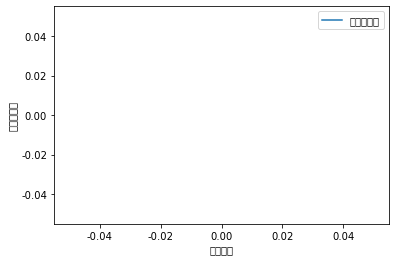

In [6]:
#将所有回合得分进行可视化
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.plot(agent.scores, label='智能体得分')
plt.xlabel('回合次数')
plt.ylabel('每回合得分')
plt.legend();

In [ ]:
# 计算智能体平均得分
sum(agent.scores) / len(agent.scores)

In [ ]:
# 查看在memory中的状态-动作组合，前四个数值为状态，后一个数值为动作
# memory变量中的动作一栏，有的是array形式，有的是int形式，int形式来源于直接使用随机函数sample(),array形式来源于神经网络
agent.memory[:20]

In [ ]:
# 单独提取状态
state1 = np.array([m[0][0] for m in agent.memory])
state1[0:20]

In [ ]:
# 单独提取动作
action1= np.array([m[1] for m in agent.memory])
action1[0:20]

In [ ]:
# 调用sklearn的accuracy_score计算如果全部使用神经网络（不加入随机探索部分）的准确率
accuracy_score=accuracy_score(np.where(agent.model.predict(state1) > 0.5, 1, 0), action1)
accuracy_score

In [ ]:
len(agent.memory)

注意：
此训练过程可能会很耗费CPU资源。当episodes设置为1000时，可能会耗费数小时来训练模型。在此例中我们选择episodes = 100，是一个可以接受的选项


### 6.2.2 实验总结

本实验利用神经网络来预测给定状态应该执行的动作，经过实验我们得到的准确率为75%左右。 整个过程可以将神经网络看成一个黑匣子：输入是小车的状态，输出是给定状态应该执行的动作。虽然我们不关心智能体内部完成任务的过程，但是输出结果是稳定的，这也是神经网络的一大特点。

通过以上“智能体得分”图像我们可以观察到，这个神经网络智能体的预测能力并不高，没有在第五部分中爬山算法中的结果稳定。分析下来，有以下原因：

1. 探索概率较大。我们选择探索概率为0.5，也就是有50%的机会都是在随机选择，另50%的机会使用神经网络，这导致了综合的预测能力减弱

2. 每次训练模型使用的数据只是单次的[state, action],这是通过<font color=#FF9900> learn()</font> 方法中的<font color=#FF9900> self.train_model(state, action)</font> 语句来实现的。


仔细观察<font color=#FF9900> learn()</font> 方法，此方法记录了每一次重置状态后得到的动作。如果此动作能够使小车的结束条件达到，也就是Done=True，则记录得分。如果不能达到结束条件，即成功保持小车能够继续的状态（Done=False）, 则将结果记录在案，形成<font color=#FF9900> self.memory </font> 训练集，以供下次继续使用帮助预测。但存在的问题是，训练模型的时候使用的是<font color=#FF9900> self.train_model(state, action)</font> ，此算法回避了那些能够终止小车继续运行的动作进入神经网络的模型，而每次训练也只加入了上一次成功的案例，使得成功的训练集太小。另一方面，可以将这个网络理解为，“努力预测使得下一次的动作不会导致done=True，以便小车能够继续运行下去”，此种方法并没有使优化的着眼点定位在200次成功，而是单次的成功。

为了解决此问题，我们需要记录所有曾使用过的状态和状态对应的动作实数对，进行神经网络建模，这样就可以根据后续产生的回报最大限度地预测新的动作。使用此种神经网络的预测的目的将状态-动作进行评分，就像第三部分中的迷宫案例，智能体选择每一次状态-动作值最高的一步。对于系统状态非常多的情况，更多的是使用Q值计算函数而非Q表形式来选择最优动作，进而对Q策略进行评分。

神经网络可以用来作为估计Q值的一个自然选择，这个思想就是深度强化学习。而加入之前成功的案例，就是带有经验回放的的强化学习，下一个实验将综合两种思想。

## 6.3 深度强化学习智能体

### 6.3.1 深度强化学习算法（Deep Q-Learning, DQN）

DQN算法是 DeepMind 团队在2015年提出的算法，对于强化学习训练问题，其开创性的提出了两个解决办法，在Atari游戏上都有不俗的表现。论文发表在 Nature 上，此后的一些DQN相关算法都是在其基础上改进，可以说是打开了深度强化学习的大门，意义重大。

DQN就是Q-学习算法 + 神经网络。从第三部分的实验中，我们知道Q-学习算法需要维护一张Q表格，按照下面公式来更新：

$$Q(S_{t},A_{t}) \leftarrow Q(S_{t},A_{t})+\alpha[R_{t+1}+ \gamma max_{a}Q(S_{t+1},a_{t})-Q(S_{t},A_{t})] $$

学习的过程就是更新Q表格的过程。而DQN就是用神经网络来代替这张Q表，其更新过程为：


$$Q(S_{t},A_{t}，\omega) \leftarrow Q(S_{t},A_{t},\omega)+\alpha[R_{t+1}+ \gamma max_{a}\hat{q}(S_{t+1},a_{t},\omega)-Q(S_{t},A_{t},\omega)] $$

其中，$\omega$表示了神经网络的权向量。

下图表示了Q学习以及深度强化学习DQN的区别：

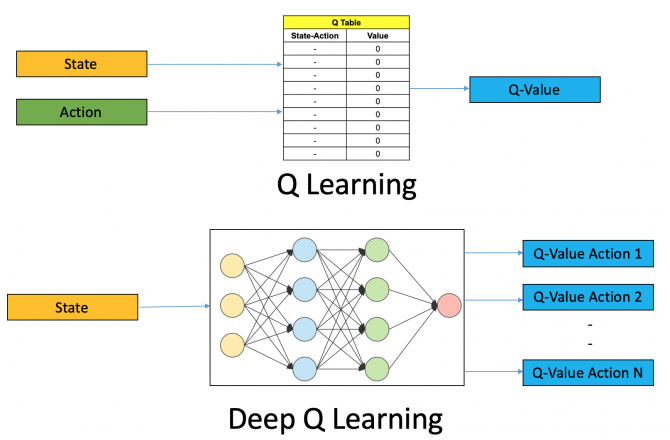

### 6.3.2 实验：深度强化学习解决单摆车问题

【实验目的】

+ 使用深度网络代替Q表，形成策略估计器

+ 通过强化学习来优化深度学习网络估计器

【实验要求】

+ 运行以下所有单元格
+ 逐行键入代码，结合深度强化学期DQN算法，<font color=red>仔细研读</font>代码及相关注释
+ 能够自我编写深度网络，完成强化学习解决单摆车问题
+ 梳理类DQLAgent()的编写结构

【实验步骤】

+ 逐行键入以下代码，仔细阅读代码注释并观察代码执行结果，理解每行代码的用意
+ 仔细阅读DQLAgent()类的补充说明
+ 将类中的learn()方法拆解开来，新建notebook单元格，分别执行并阐述其意义，观察运行结果



In [7]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4,suppress=True) #将打印格式设置为4位小数和不用科学计数法显示

import gym 

# 以下的导入库是Keras常用操作
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score

from collections import deque #双向队列用于存储有限记忆，目的是只关注最后2000次的记忆

In [8]:
import random

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
#     env.seed(seed)
    env.action_space.seed(seed)

In [9]:
class DQLAgent:
    def __init__(self, gamma=0.95, hu=24, opt=Adam, lr=0.001, batch_size=32,finish=False):
        self.finish = finish 
        #控制变量，在learn方法中，定义每一回合执行动作5000次，如果设置回报达到195则认为此回合成功，提前终止训练，
        #此变量控制是否可以提前结束
        
        self.epsilon = 1    #探索概率，后续有逐渐衰减的过程
        self.epsilon_min = 0.01    #探索概率衰减的最小值
        self.epsilon_decay = 0.995  #探索概率衰减值
        
        self.gamma = gamma           #回报贴现率/折扣率
        
        self.batch_size = batch_size         #进入神经网络的批次数量
        
        self.max_treward = 0         #设置最大总回报
        self.averages = list()       #存储平均回报
        
        self.memory = deque(maxlen=2000)  
        #deque是一种双向队列，可以理解为长度有限的数组，可在左侧或者右侧来推入数据时保持数组长度不变
        #双向队列对于存储临时数据或时间序列数据很有效，可以仅仅考虑近期数据，而不考虑远期数据
        
        self.osn = env.observation_space.shape[0] 
        #获取初始状态空间的元素数量，此例中为4
        #类被实例化之前，需要将env定义好（金融案例中还会遇到这个问题）
        
        self.model = self._build_model(hu, opt, lr) 
        #定义估计模型，为_build_model()函数中所指定的深度神经网络，hu=hidden units
        #注意：类声明中，构造函数包含方法，声明时即被执行
        
    def _build_model(self, hu, opt, lr):           #深度神经网络模型，与上一例有所不同，上例是用来估计动作，此例用来估计Q值
        model = Sequential()
        
        model.add(Dense(hu, input_dim=self.osn,    #建立输入层，input_dim这个位置必须给与足够重视，它表示输入的数据的维度，
                        activation='relu'))        #实际搭建神经网络尽量避免；神经网络第一个add方法加入了输入层和第一个隐藏层
                                                    #self.osn=4,表示有四个变量作为输入，输入维度为4；四个变量 对应小车的状态四元组
        
        model.add(Dense(hu, activation='relu'))             #加入第二隐藏层
        
        model.add(Dense(env.action_space.n, activation='linear'))   
        #加入输出层，动作空间action_space.n=2，这的目的是预测两个变量0或者1代表的Q值
        #会选择值较大的作为估计器，所以输出值为不懂动作下（0或1）的Q值
            
        model.compile(loss='mse', optimizer=opt(learning_rate=lr))  
        #编译深度神经网络，指定损失函数和优化方法；MSE均方误差为回归问题
        return model
        
    def act(self, state):
        if random.random() <= self.epsilon:        #random.random()用于生成一个0到1的随机符点数，epsilon用于定义探索概率
            return env.action_space.sample()       #返回动作空间的随机抽样，动作空间只有0和1.
                                                    #此过程为探索过程
            
        action = self.model.predict(state)[0]       #调用_build_model()中所建立的深度神经网络模型进行预测
                                                    #注意，此位置输出为两个数，env.action_space.n=2,需要选择最大的那个，
                                                    #[0]将二维数组变为一维数组，将[[a,b]]降维成[a,b]。a,b表示动作0,1对应的Q值
                                                                                                         
        return np.argmax(action)             #np.argmax返回一个数组中最大值的索引值。最大值出现多次时，返回第一个最大值的索引值。
                                     #此处与NNAgent.act有所不同
    
    def replay(self):  
        
         #经验回放函数从memory里随机抽取batch_size个样本，默认32，进行神经网络预测
        batch = random.sample(self.memory, self.batch_size)                
        
        for state, action, reward, next_state, done in batch: #对于memory中所有的数据，进行遍历;
                                                               #注意此位置必须加入next_state以确保神经网络能够捕捉到“延迟的回报”
                                                               #此处是DQLAgent与NNAgent的显著区别
                                                               #延迟的回报是由一下model.predict预测数来的
            if not done: #对成功的动作进行遍历
                reward += self.gamma * np.amax(self.model.predict(next_state)[0])   
                #Q学习公式：reward=reward+gamma*神经网络的预测值
                #np.amax（等价于np.max）返回数组中的最大值
            
            target = self.model.predict(state)             #目标为神经网络的预测
            target[0, action] = reward
                #注意此位置target为列表二元组，第一个元素为状态（状态自身为四元组），第二个元素为带有折扣的回报
            
            self.model.fit(state, target, epochs=1,verbose=False)   #训练过程
        
        if self.epsilon > self.epsilon_min:       #调整探索概率，逐渐递减
            self.epsilon *= self.epsilon_decay
    
    
    
    
    def learn(self, episodes):              #learn函数是学习过程的核心，接收一个参数episodes回合
                                            #学习过程，和之前的神经网络一样
                                            #注意此函数是深度强化学习的学习函数，将在后续的金融实例中使用
            
        trewards = []                       #定义总回报列表，记录每一回合学习结果
        
        for e in range(1, episodes + 1):     #循环重复episodes次
            
            state = env.reset()[0]               #重置环境变量，注意初始的状态维度为：(4,)
            
            state = np.reshape(state, [1, self.osn])   #将收集到的状态变量进行展平：[位移，速度，角度，角速度]，展平成[[1,4]]数组
            
            for _ in range(5000):             #定义5000次，之前是200次
                
                action = self.act(state)      #调用类中的act()函数，函数返回随机动作或者由深度神经网络预测出来的最大Q值的动作
                
                next_state, reward, done, truncated, info = env.step(action)  #调用env.step()函数，返回执行动作后的状态，回报，done，info
                
                next_state = np.reshape(next_state,[1, self.osn]) 
                #目的是将next_state在后续作为新的训练集输入给神经网络
                #将新状态展平：[位移，速度，角度，角速度]，维度1*4
                
                self.memory.append([state, action, reward, next_state, done]) 
                #将当前状态，动作，回报，下一个状态，done储存给memory
                #memory记忆体用于神经网络预测，注意记忆体是个只能存2000组数据的双向队列,append从右侧推入
                    
                state = next_state   
                #变量state用于存储“当前”状态，即执行动作完成以后，新状态仍然存储在state里面，next_state只用于过渡
                
                if done:          #如果中间有一次失败，即done=True
                    
                    treward = _ + 1            #treward总回报=循环次数+1，表示此回合结束以后总回报是多少
                    
                    trewards.append(treward)   #将总回报treward插入所有回合的总回报列表trewards中， 注意trewards是在循环外声明的列表，
                                               #treward为刚刚声明的临时变量
                    
                    av = sum(trewards[-25:]) / 25              
                    #计算最后25个总回报的均值，目的是看随着回合数的增加，看最后25回合的平均回报是否增加，也就是学习能力是否有提升
                    
                    self.averages.append(av)                    #将最后25个总回报的均值均值计入averages列表，averages为全局变量
                    
                    self.max_treward = max(self.max_treward, treward) 
                    #检查当前回合中最大总回报是否与当次相同，如果当次高则更新最大总回报
                    
                    templ = 'episode: {:4d}/{} | treward: {:4d} | '   
                    templ += 'av: {:6.1f} | max: {:4d}'
                                    
                    print(templ.format(e, episodes, treward, av,
                                       self.max_treward), end='\r')   #打印回合进程
                    break
            
            if av > 195 and self.finish:      #如果平均回报大于195,且实例化时如果指定finish=True时，提前结束训练
                break
                
            if len(self.memory) > self.batch_size:    #如果记忆体数目大于batch_size(32),执行经验回放函数
                self.replay()                          
                
    
    
    def test(self, episodes):              #测试函数，测试函数没有探索，只有利用。和实际应用中的一样；神经网络已经训练完不再训练
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            for _ in range(5001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model.predict(state)[0])  #选择深度网络预测值中最大的索引作为动作
                next_state, reward, done, truncated, info = env.step(action)
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:4d}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

In [10]:
episodes = 1000

In [11]:
env=gym.make('CartPole-v1')
set_seeds(100)
agent = DQLAgent(finish=True)

In [ ]:
%%time 

agent.learn(episodes)         #注意：此位置学习时间可能较长，1000回合应该在1小时以上
                              #可以访问google colab部署在线服务器，使用网络GPU
    

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


由于训练时间较长，可以将训练好的模型保存，再次读取


In [ ]:
# 保存训练好的模型
save_model_name='model-'+str(episodes)+'.h5'
agent.model.save(save_model_name)

In [ ]:
# 也可以单独保存神经网络的权重
agent.model.save_weights('my_model_weights.h5')
# 读取保存的模型
agent.model.load_weights('my_model_weights.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)  #polyval用特定值评估多项式;
#polyfit函数用于进行曲线拟合的一个函数。其数学基础是最小二乘法曲线拟合原理


#保存图像
plt.plot(agent.averages, label='回报移动平均')
plt.plot(x, y, 'r--', label='趋势')
plt.xlabel('回合次数')
plt.ylabel('总回报')
plt.legend();
save_fig_name='model-'+str(episodes)+'.png'
plt.savefig(save_fig_name)

In [ ]:
%%time
#测试DQN实例1000次
trewards = agent.test(200)

In [ ]:
sum(trewards) / len(trewards)

In [ ]:
agent.memory

### 6.3.3 实验总结

经过带有经验回放的深度神经网络模型的强化学习，我们看到随着回合数目的增加，总回报率在上升。测试1000次的过程中，得到的回报平均值为200，则可以认为，单摆车问题得以解决。

我们总结一下DQLAgent，它的核心是利用带有经验回放的深度学习模型更新Q表，使得更多的状态-动作实数对作为训练集来预测动作，并在Q表中进行评分。在探索环境之前，智能体并不知道环境的状态，只有认为定义的动作空间，随着探索+利用逐渐累积，智能体学会了足够多的状态-实数对，并且利用神经网络对于新的状态有足够多的认识，能够预测正确的动作。这就是强化学习的目的。

随着回合数目的增加，仍然会看到有回报非常低的情况，是因为有探索的存在，随机选择了一些动作使得总回报下降。

注意：回合数会严重影响训练时间，为了节约时间可加载已经训练好1000次或者2000次的模型。

In [ ]:
#可以加载已经训练好的模型
from tensorflow.keras.models import load_model
agent.model = load_model("DQNAgent_1000.h5")

下图为训练1000次的结果：
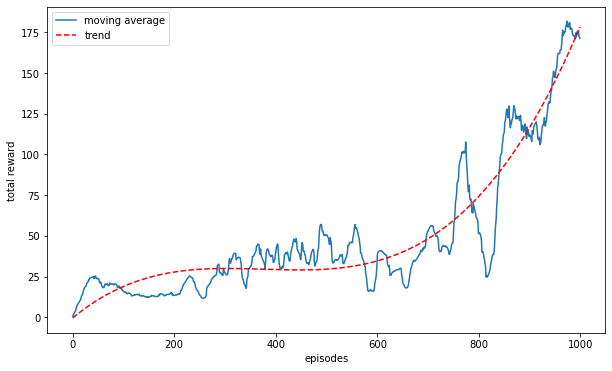